This notebook replicates the second experiment with LeNet on MNIST dataset from our paper "MARS: Masked Automatic Ranks Selection in Tensor Decompositions".

Compression mode: **compress** ($\pi = 10^{-2}$, $\alpha = 0$).

**Preliminaries**

In [1]:
import os

os.chdir("../main")

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import torch
import numpy as np
import random

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

from mars import MARSLoss, get_MARS_attr, set_MARS_attr
from models import LeNet

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
seed = 228  # set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Model and hyperparameters definition**

In [5]:
# Compression modes parameters
modes_dict = {
    "base": dict(pi=np.nan, alpha=np.nan),
    "compress": dict(pi=1e-2, alpha=0)
}

In [6]:
# Hyperparameters section
# In this experiment, we take enough epochs to guarantee complete convergence.
# One can take fewer but adjust the temperature annealing schedule appropriately.
n_epochs = 100  
batch_size = 128
lr = 5e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.97
temp_anneal = lambda t: max(1e-2, gamma * t)

In [7]:
data_dir = "/home/sergej/data"
test_batch = 2048

# MNIST Dataset (Images and Labels)
trainset = datasets.MNIST(root=data_dir,
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

testset = datasets.MNIST(root=data_dir,
                         train=False,
                         transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=testset,
                                         batch_size=test_batch,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


**Functions definition**

In [8]:
def train_model(model_idx, mode="soft", save=True, load=True):
    """
    Train the model or load the trained one.
    
    Parameters are:
        model_idx : int
            Model index to load or save.
        mode : str in {'soft', 'hard'}
            Compression mode.
        save : bool
            Whether to save the trained model.
        load : bool
            Whether to load the trained model.
    """
    model_directory_path = f"../models/MNIST-LeNet/{mode}/"
    prefix = str(model_idx)
        
    model_path = model_directory_path + prefix + '-model.pt'
    losses_path = model_directory_path + prefix + '-losses.npy'
    print("Model path: ", model_path)

    if save and not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
        
    model = LeNet(config, **modes_dict[mode]).to(device)
    
    if load and os.path.isfile(model_path):
        # load trained model parameters from disk
        model.load_state_dict(torch.load(model_path))
        losses = np.load(losses_path)
        print('Loaded model parameters from disk.')
        return model, losses
    
    cross_entropy = nn.CrossEntropyLoss()
    criterion = MARSLoss(model, len(trainset), cross_entropy)
    optimizer = optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)
#     scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **{
        "steps_per_epoch": len(trainloader),
        "epochs": n_epochs,
        "anneal_strategy": "cos",
        "max_lr": lr,
        "pct_start": 0.1
    })

    print("Training...")
    model.train()
    losses = []
    log_step = len(trainloader)
    best_train_acc = 0
    best_test_acc = 0
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        losses.append(0.0)

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses[-1] += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # update statistics
            with torch.no_grad():
                running_loss += loss.item()
                predicted = outputs.argmax(-1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_acc = correct / total
        test_acc = eval_model(model)
        temp = get_MARS_attr(model, "temperature")
        print('[%d] \t Loss: %.3f \t Train Acc: %.2f%% \t Test Acc: %.2f%% \t T: %.3f' %
              (epoch + 1, 
               running_loss / log_step,
               100 * train_acc,
               100 * test_acc, 
               np.nan if temp is None else temp))
                
        losses[-1] /= i + 1
        
        if save:
            if train_acc > best_train_acc:
                torch.save(model.state_dict(), model_path[:-3] + "-best_train.pt")
                best_train_acc = train_acc
                best_train_epoch = epoch + 1
            if test_acc > best_test_acc:
                torch.save(model.state_dict(), model_path[:-3] + "-best_test.pt")
                best_test_acc = test_acc
                best_test_epoch = epoch + 1
        
        temp = get_MARS_attr(model, "temperature")
        if temp is not None:
            new_temp = temp_anneal(temp)
            set_MARS_attr(model, "temperature", new_temp)

    losses = np.array(losses)
    print('Finished Training.')
    print("Best train accuracy:\t%.2f%% on epoch %d" % (100 * best_train_acc, best_train_epoch))
    print("Best test accuracy:\t%.2f%% on epoch %d" % (100 * best_test_acc, best_test_epoch))
    
    if save:
        torch.save(model.state_dict(), model_path)
        np.save(losses_path, losses)
        print('Saved model parameters to disk.')
    
    return model, losses

In [9]:
def eval_model(model):
    "Evaluate a single model on test set."
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def eval_ensemble(models):
    "Evaluate the whole ensemble on test set."
    for model in models:
        model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = torch.stack([model(images) for model in models])
            outputs = torch.softmax(outputs, -1)
            outputs = outputs.mean(0)
                
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [11]:
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()
            
            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()
        
        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]
        
        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params
    
    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)
    
    return total_comp

**MARS training**

In [ ]:
from dataclasses import dataclass

@dataclass
class MNISTLeNetConfig:
    mars_enabled = True

config = MNISTLeNetConfig()

In [14]:
model, loss = train_model(0, mode="soft")
acc = eval_model(model)
print(f"Accuracy of base model:\t%.2f%%" % (100 * acc))

Model number 1...
Model path:  ../models/CIFAR10-ResNet/soft/1-model.pt
Training...


RuntimeError: shape '[-1, 16, 3, 3]' is invalid for input of size 512

Model number 1...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


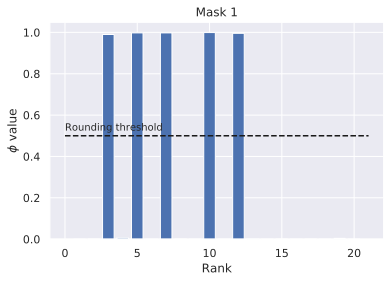

#nz ranks: 5/20


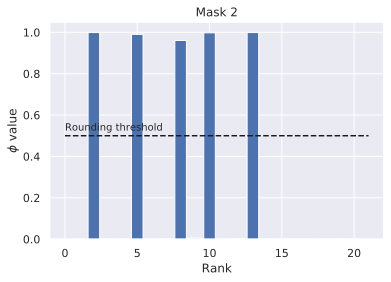

#nz ranks: 5/20


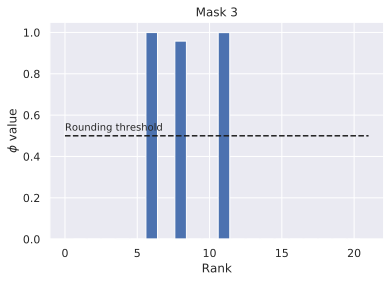

#nz ranks: 3/20

Compression:	388.889
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


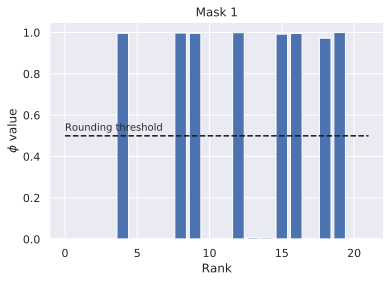

#nz ranks: 8/20

Compression:	4.464
Total compression:	150.800


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 2...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


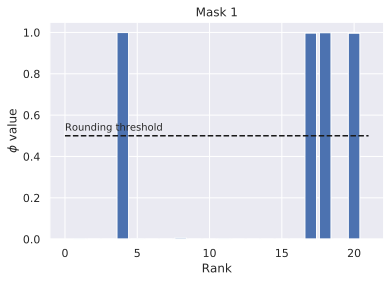

#nz ranks: 4/20


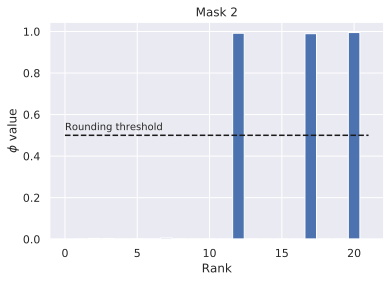

#nz ranks: 3/20


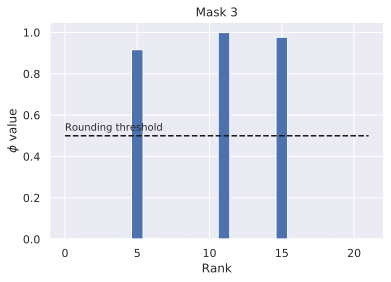

#nz ranks: 3/20

Compression:	649.007
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


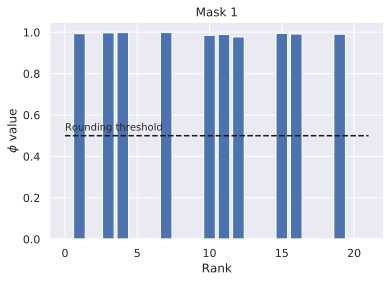

#nz ranks: 10/20

Compression:	3.571
Total compression:	158.244


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 3...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


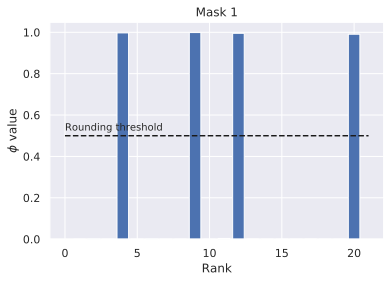

#nz ranks: 4/20


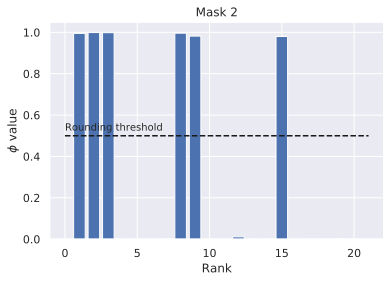

#nz ranks: 6/20


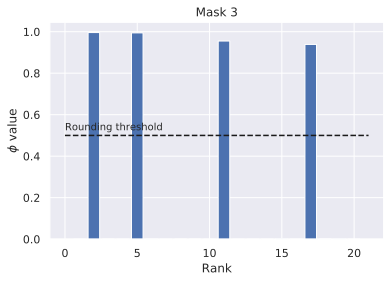

#nz ranks: 4/20

Compression:	318.182
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


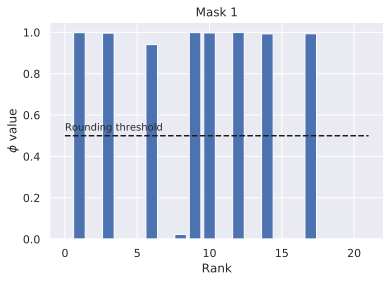

#nz ranks: 8/20

Compression:	4.464
Total compression:	138.989


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 4...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


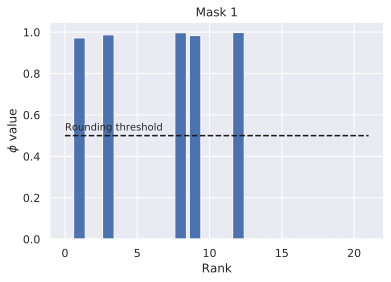

#nz ranks: 5/20


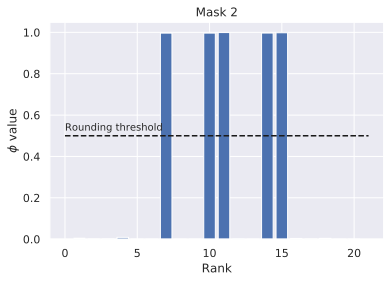

#nz ranks: 5/20


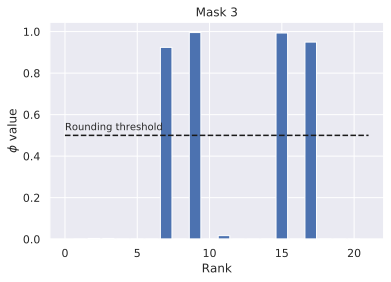

#nz ranks: 4/20

Compression:	336.770
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


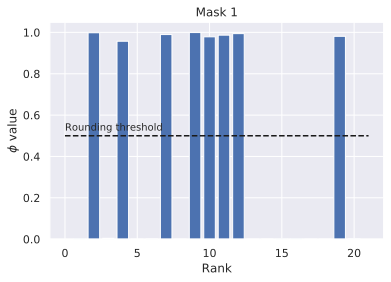

#nz ranks: 8/20

Compression:	4.464
Total compression:	142.374


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 5...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


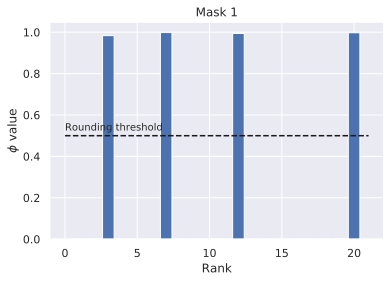

#nz ranks: 4/20


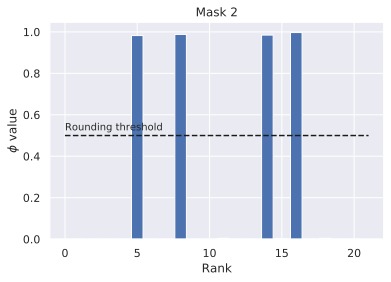

#nz ranks: 4/20


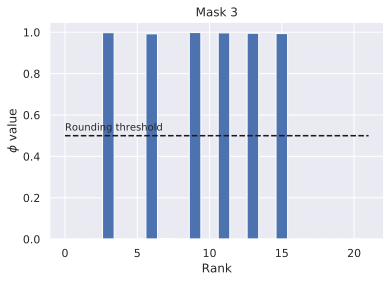

#nz ranks: 6/20

Compression:	345.070
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


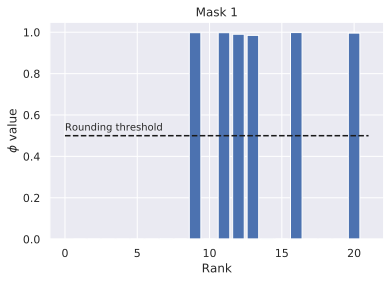

#nz ranks: 6/20

Compression:	5.952
Total compression:	160.027


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 6...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


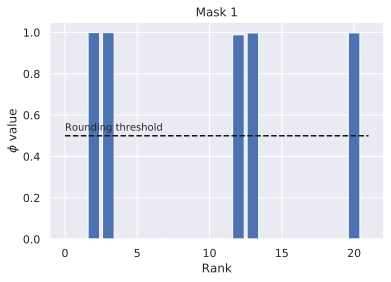

#nz ranks: 5/20


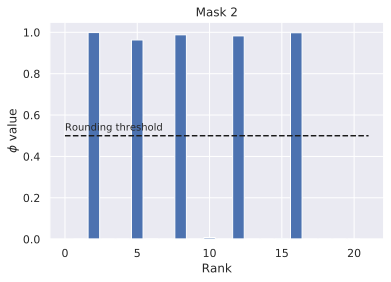

#nz ranks: 5/20


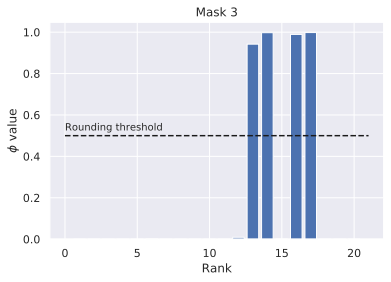

#nz ranks: 4/20

Compression:	336.770
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


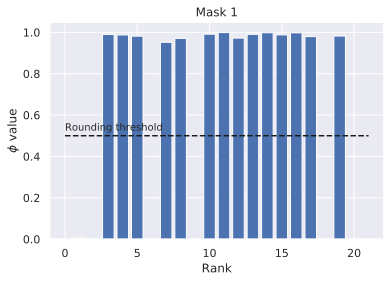

#nz ranks: 14/20

Compression:	2.551
Total compression:	109.446


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 7...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


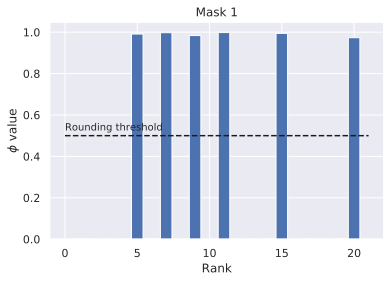

#nz ranks: 6/20


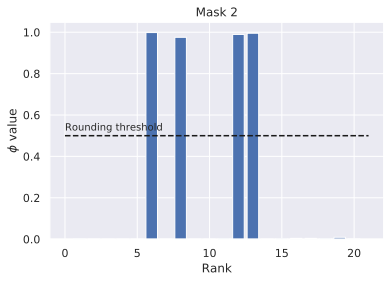

#nz ranks: 4/20


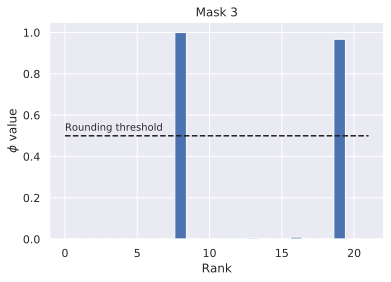

#nz ranks: 2/20

Compression:	485.149
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


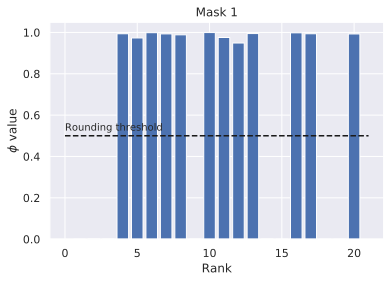

#nz ranks: 12/20

Compression:	2.976
Total compression:	132.680


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 8...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


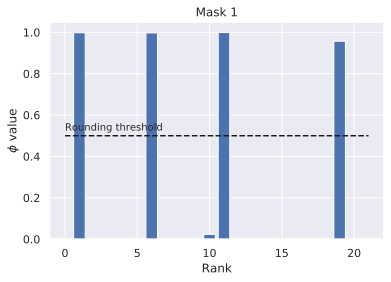

#nz ranks: 4/20


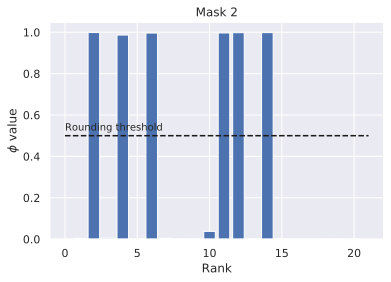

#nz ranks: 6/20


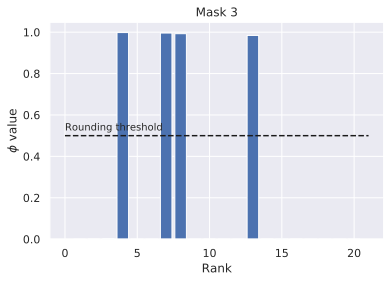

#nz ranks: 4/20

Compression:	318.182
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


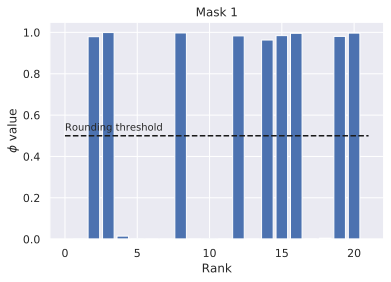

#nz ranks: 9/20

Compression:	3.968
Total compression:	132.503


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 9...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


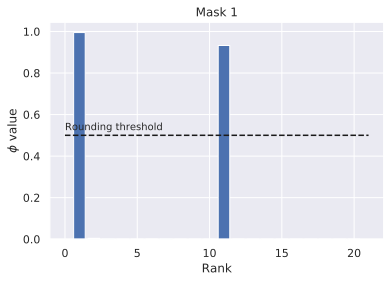

#nz ranks: 2/20


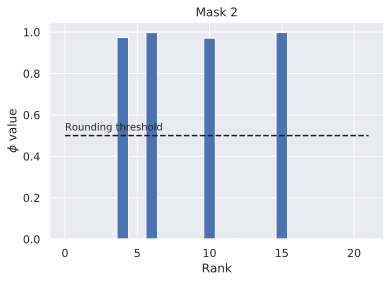

#nz ranks: 4/20


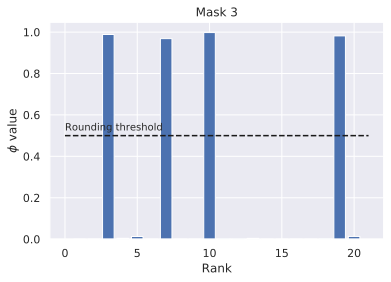

#nz ranks: 4/20

Compression:	563.218
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


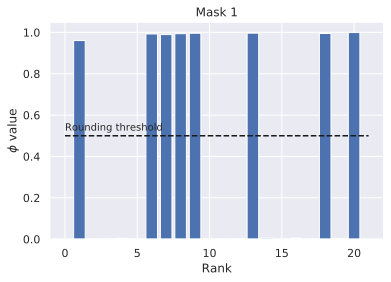

#nz ranks: 8/20

Compression:	4.464
Total compression:	171.045


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 10...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


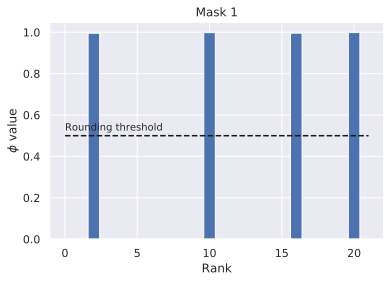

#nz ranks: 4/20


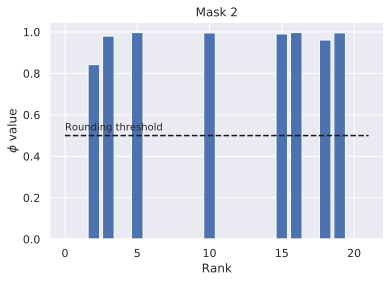

#nz ranks: 8/20


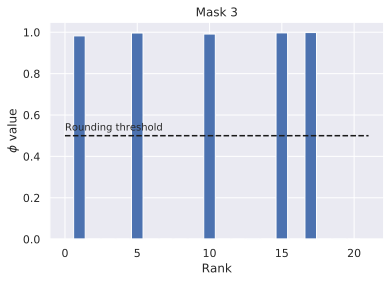

#nz ranks: 5/20

Compression:	214.912
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


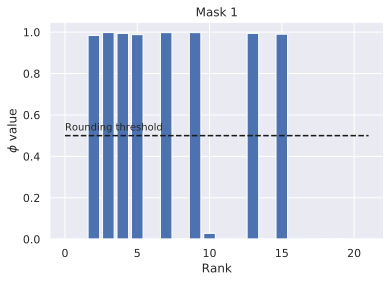

#nz ranks: 8/20

Compression:	4.464
Total compression:	115.153


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [14]:
comp = get_comp_info(model)

**MARS ensemble training**

In [13]:
n_models = 10  # set the number of models in ensemble
mode = "compress"  # set the compression mode
models, losses = [], []

In [ ]:
for k in range(1, n_models + 1):
    print(f"Model number {k}...")
    model, loss = train_model(k, mode)
    losses.append(loss)
    models.append(model)
    print()
    print(100*'=')
    print()

In [ ]:
comps = []

for k, model in enumerate(models, 1):
    print(f"Model number {k}...")
    print()
    comps.append(get_comp_info(model))
    print()
    print()
    print(100*'-')
    print(100*'-')
    print(100*'-')
    print()
    print()

In [15]:
accuracies = dict()

accuracies["marginal"] = []
for k, model in enumerate(models, 1):
    k_acc = eval_model(model)
    print(f"Accuracy of model {k}:\t%.2f%%" % (100 * k_acc))
    accuracies["marginal"].append(k_acc)
    
print()

ensemble_acc = eval_ensemble(models)
print('Accuracy of the ensemble:\t%.2f%%' % (100 * ensemble_acc))
accuracies["ensemble"] = ensemble_acc

Accuracy of model 1:	98.01%
Accuracy of model 2:	98.09%
Accuracy of model 3:	98.30%
Accuracy of model 4:	98.29%
Accuracy of model 5:	98.08%
Accuracy of model 6:	98.23%
Accuracy of model 7:	98.24%
Accuracy of model 8:	98.02%
Accuracy of model 9:	98.00%
Accuracy of model 10:	98.16%

Accuracy of the ensemble:	98.91%


In [16]:
for k, comp in enumerate(comps, 1):
    print(f"Model {k} total compression:\t%.3f" % comp)

Model 1 total compression:	150.800
Model 2 total compression:	158.244
Model 3 total compression:	138.989
Model 4 total compression:	142.374
Model 5 total compression:	160.027
Model 6 total compression:	109.446
Model 7 total compression:	132.680
Model 8 total compression:	132.503
Model 9 total compression:	171.045
Model 10 total compression:	115.153
